In [5]:
import numpy as np 
import scanpy as sc 
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns 
import anndata as ad 
import scanpy.external as sce 

def count_summary(neuron, key_1 , key_2 = 'samples'):
        anno_df = neuron.obs.copy()
        anno_df.head()

        df = anno_df 
        # 1. 按col1和col2分组，统计每个组合的数量
        grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')

        # 2. 按col1分组，计算总数
        total_counts = df.groupby(key_2).size().reset_index(name='total_count')

        # 3. 合并数据，计算比例
        merged = grouped.merge(total_counts, on=key_2)
        merged['proportion'] = merged['count'] #/ merged['total_count']

        # 4. 重新排序和格式化结果
        result = merged[[key_2, key_1, 'proportion']]

        result = result.pivot(index=key_1, columns=key_2, values='proportion')
        return result


In [2]:
scdata = sc.read_h5ad('final_hvg.h5ad')
scdata

AnnData object with n_obs × n_vars = 26222 × 2670
    obs: 'species', 'tissues', 'samples', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster', 'celltype', 'coarse_celltype', 'eco'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'eco_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'species_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

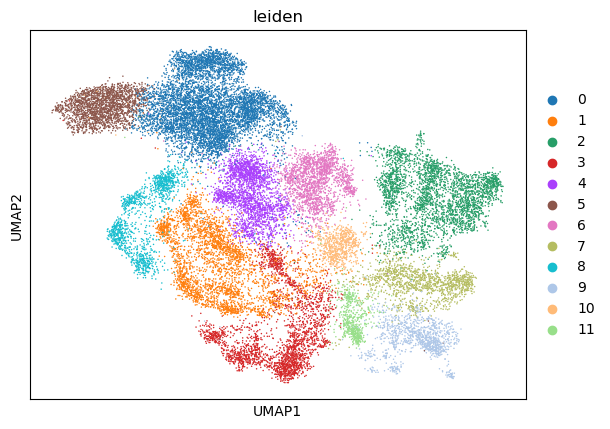

In [3]:
sc.pl.umap(scdata, color = 'leiden')

d:\Anaconda\envs\scanpy-1.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


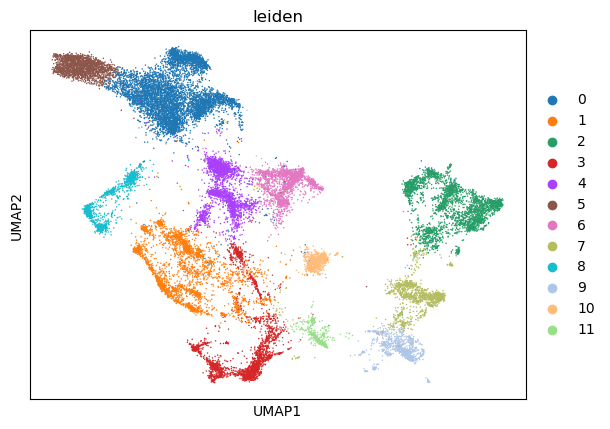

In [4]:
sc.tl.umap(scdata, min_dist = 0.1)
sc.pl.umap(scdata, color = 'leiden')

In [6]:
count_summary(scdata, 'leiden', 'species')

C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


species,CY,JT,M,QF,T
leiden,,,,,
0,1446,1422,0,0,3359
1,973,1146,257,559,237
2,1017,892,214,711,291
3,12,252,646,667,880
4,1210,1037,0,0,116
5,0,10,899,412,673
6,817,903,34,12,75
7,306,528,186,108,210
8,686,592,6,17,33


### 导入小鼠注释

In [ ]:
mdata = scdata[scdata.obs.species =='M']
print(mdata.shape)

#mhm_anno = pd.read_csv('allen_21_mhm.csv')
#mhm_anno = pd.read_csv('mhm_anno.csv', index_col= 'Unnamed: 0')
mhm_anno.index = 'MHM-' +  mhm_anno.index.values
mutual_idx = np.intersect1d(mhm_anno.index.values, mdata.obs.index.values)
print(mutual_idx.shape)

mdata = mdata[mutual_idx]
mhm_anno = mhm_anno.loc[mutual_idx]

(2841, 2670)
(2841,)


In [26]:
pred_class_label = []
pred_class = mhm_anno.iloc[:,10:]

for ele in np.argmax(pred_class.values, axis = 1):
    pred_class_label.append(pred_class.columns[ele])
mdata.obs.loc[:,'pred_class'] = pred_class_label

coarse_dic = {}
for celltype, counts in mdata.obs.pred_class.value_counts().items():
    if counts >= 10:
        coarse_dic[celltype] = celltype
    else: 
        coarse_dic[celltype] = 'unclear'
mdata.obs.loc[:,'celltype_vis'] = mdata.obs.pred_class.map(coarse_dic)

d:\Anaconda\envs\scanpy-1.10\lib\site-packages\pandas\core\indexing.py:1857: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


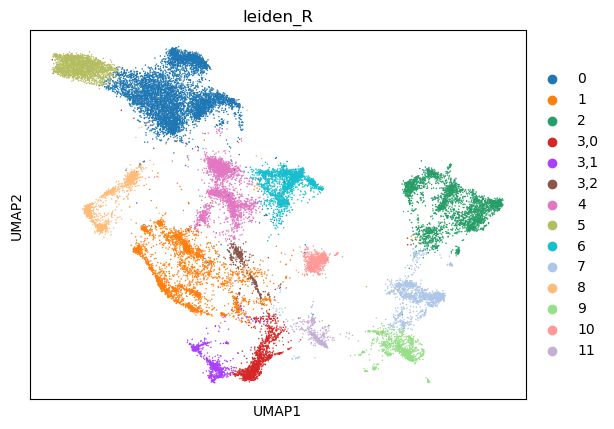

In [34]:
sc.tl.leiden(scdata, resolution= 0.2, restrict_to=['leiden',['3']])
sc.pl.umap(scdata, color = 'leiden_R')

In [19]:
count_summary(scdata, 'leiden_R', 'species')

C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


species,CY,JT,M,QF,T
leiden_R,,,,,
0,1446,1422,0,0,3359
1,973,1146,257,559,237
2,1017,892,214,711,291
"3,0",0,8,420,173,704
"3,1",5,12,172,450,115
"3,2",7,232,54,44,61
4,1210,1037,0,0,116
5,0,10,899,412,673
6,817,903,34,12,75


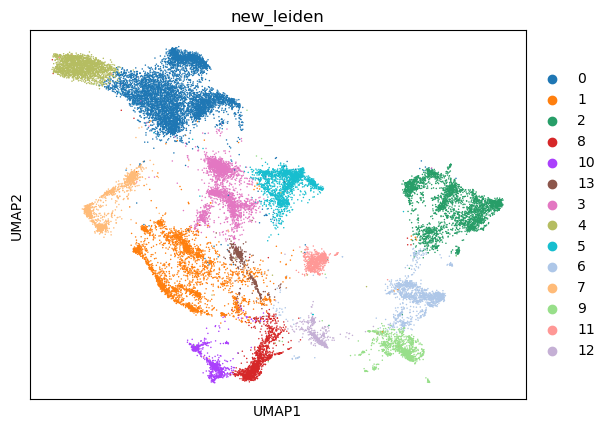

In [24]:
tmp = dict(scdata.obs.leiden_R.value_counts())

new_leiden = {}
i = 0
for key in tmp:
    new_leiden[key] = str(i)
    i += 1 

scdata.obs['new_leiden'] = scdata.obs['leiden_R'].map(new_leiden)
sc.pl.umap(scdata, color = 'new_leiden')

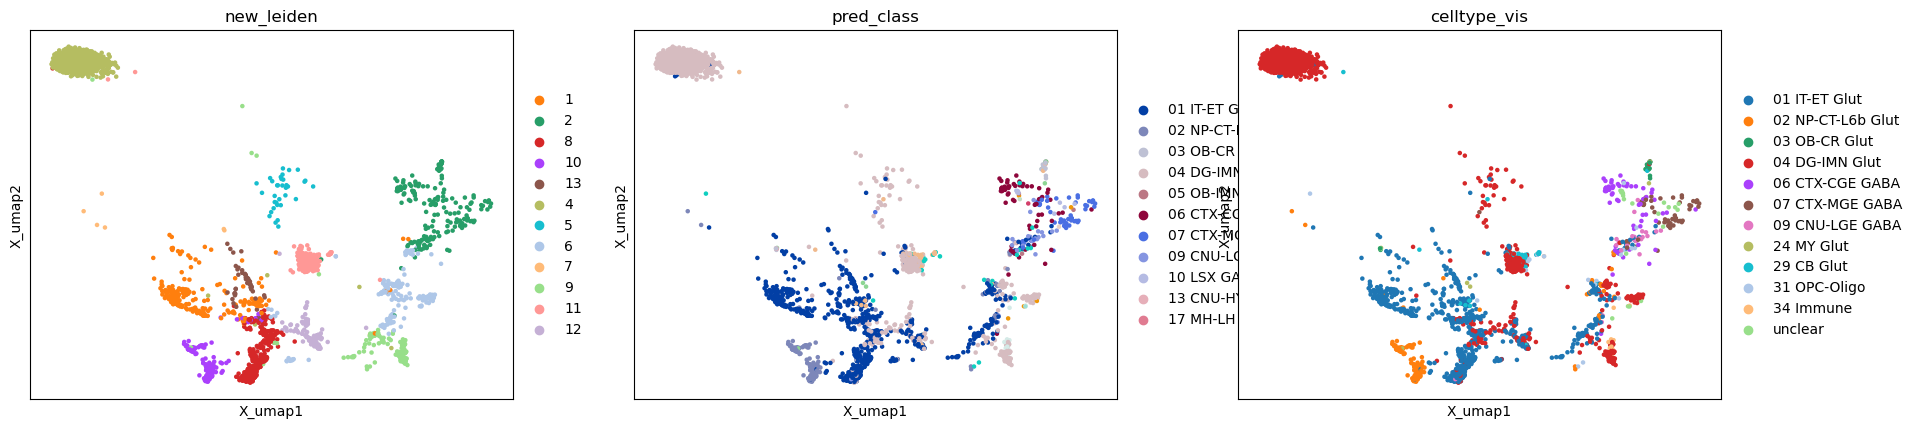

In [27]:
sc.pl.embedding(mdata, basis = 'X_umap', color = ['new_leiden','pred_class','celltype_vis'])

In [36]:
count_summary(scdata, 'new_leiden', 'species')

C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


species,CY,JT,M,QF,T
new_leiden,,,,,
0,1446,1422,0,0,3359
1,973,1146,257,559,237
2,1017,892,214,711,291
8,0,8,420,173,704
10,5,12,172,450,115
13,7,232,54,44,61
3,1210,1037,0,0,116
4,0,10,899,412,673
5,817,903,34,12,75


In [41]:
print(scdata.shape)
drop_id_1 = np.logical_and(scdata.obs.new_leiden == '3', scdata.obs.species == 'T')
drop_id_2 = np.logical_and(scdata.obs.new_leiden == '7', scdata.obs.species.isin(['M','QF','T']))
print(drop_id_1.sum(),drop_id_2.sum())

drop_id = np.logical_or(drop_id_1,drop_id_2)
print(drop_id.sum())

scdata = scdata[~drop_id,:]
print(scdata.shape)
count_summary(scdata, 'new_leiden', 'species')

(26222, 2670)
116 56
172
(26050, 2670)


C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\817895412.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


species,CY,JT,M,QF,T
new_leiden,,,,,
0,1446,1422,0,0,3359
1,973,1146,257,559,237
2,1017,892,214,711,291
8,0,8,420,173,704
10,5,12,172,450,115
13,7,232,54,44,61
3,1210,1037,0,0,0
4,0,10,899,412,673
5,817,903,34,12,75


### 导入小鼠注释完毕

C:\Users\sunrui\AppData\Local\Temp\ipykernel_81284\2359644345.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['IT-ET Glut-0' 'cy-jt specific Glut-0' 'IT-ET Glut-0' ...
 'DG-IMN Glut-(eco)' 'DG-IMN Glut-(eco)' 'DG-IMN Glut-(eco)']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  scdata.obs.loc[:,'new_anno'] = scdata.obs.new_leiden.map(new_anno_dic)


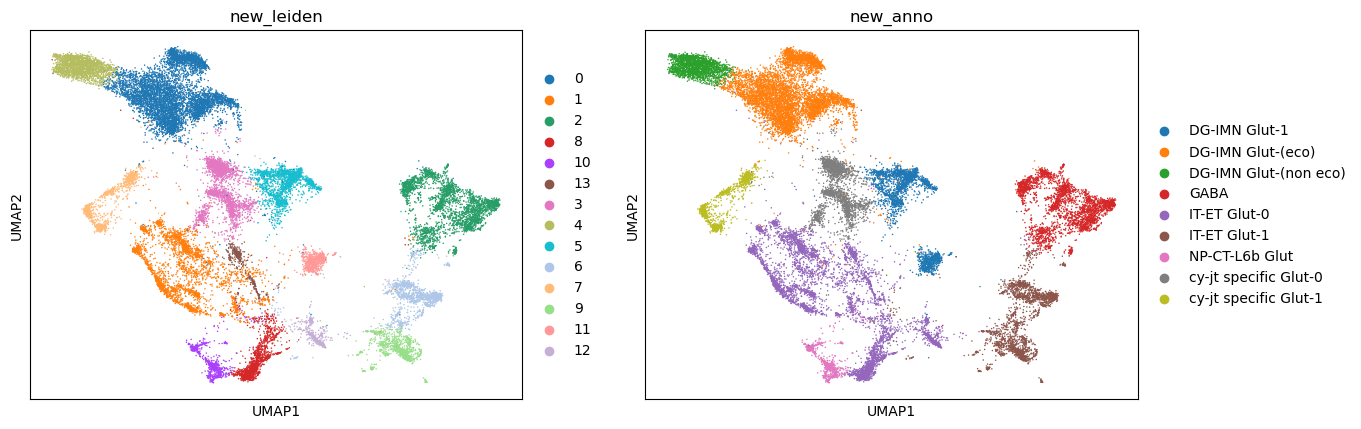

In [47]:
new_anno_dic = {'0': 'DG-IMN Glut-(eco)',
                '1': 'IT-ET Glut-0',
                '2': 'GABA',
                '3': 'cy-jt specific Glut-0',
                '8': 'IT-ET Glut-0', 
                '10': 'NP-CT-L6b Glut',
                '13': 'IT-ET Glut-0', 
                '4': 'DG-IMN Glut-(non eco)',
                '5': 'DG-IMN Glut-1',
                '6': 'IT-ET Glut-1',
                '7': 'cy-jt specific Glut-1',
                '9': 'IT-ET Glut-1',
                '11': 'DG-IMN Glut-1',
                '12': 'IT-ET Glut-0'}
scdata.obs.loc[:,'new_anno'] = scdata.obs.new_leiden.map(new_anno_dic)
sc.pl.umap(scdata, color = ['new_leiden','new_anno'])

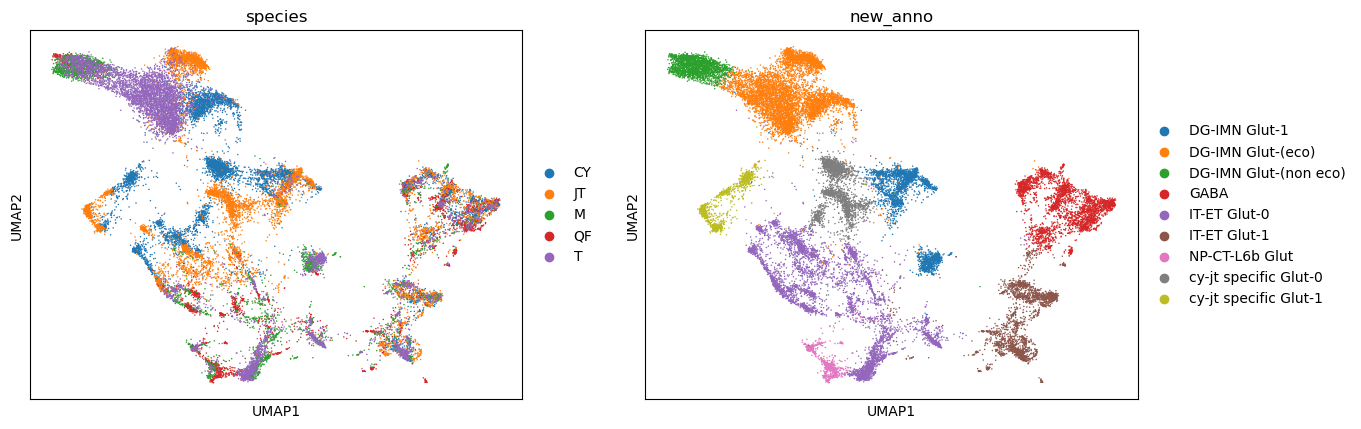

In [48]:
sc.pl.umap(scdata, color = ['species','new_anno'])